# Stack Data

In [124]:
import xml.etree.ElementTree as ET
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

def xml2pd(xml_file):
    ''' Load xml file as Pandas DataFrame'''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    cols = root[0].attrib.keys()
    rows = [child.attrib for child in root]
    return pd.DataFrame(rows, columns = cols)

## NLP

In [43]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import re, string, operator

In [84]:
stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def removeHTML(text):
    ''' Remove HTML from given text '''
    soup = BeautifulSoup(text, 'lxml')
    return soup.get_text()

def removeURLs(text):
    ''' Remove URLs from given text '''
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)

def removePunctuation(text):
    ''' Remove punctuations from given text'''
    return "".join([c for c in text if c not in string.punctuation])

def removeStopWords(text):
    ''' Remove stopwords from given text '''
    return "".join([word for word in text if word not in stopWords])

def removeStopWordsFromArray(array):
    ''' Remove stopwords from given text '''
    return [word for word in array if word not in stopWords]

def removeTags(text):
    ''' Remove code and pre tags from text '''
    soup = BeautifulSoup(text, 'lxml')
    for element in soup.find_all("code", "pre"): 
        element.decompose()
    return soup.get_text()

def lemmatizeText(text):
    ''' Lemmatize the given text '''
    return [lemmatizer.lemmatize(i) for i in text]

In [85]:
posts = xml2pd('Posts.xml')

### Question length vs Points gained

In [86]:
pointslength = pd.DataFrame(columns=["bodylen", "points", "postType", "creationTime", "creationHour"])
pointslength['bodylength'] = posts['Body'].apply(lambda x: len(x.lower()))
pointslength['points'] = pd.to_numeric(posts['Score'])
pointslength = pointslength[pd.to_numeric(pointslength.points) > 0]
pointslength['postType'] = posts['PostTypeId']
pointslength = pointslength.drop(columns="postType")
pointslength["creationTime"] = pd.to_datetime(posts['CreationDate'], format='%Y-%m-%d %H:%M:%S')
pointslength["creationHour"] = pointslength["creationTime"].dt.hour

#### Average points gained per question length histogram

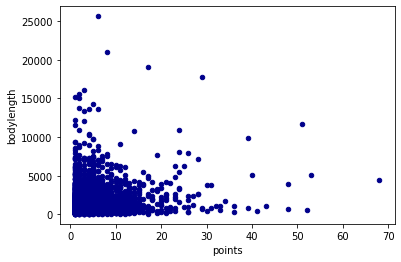

In [87]:
lengthplot = pointslength.plot.scatter(x='points', y='bodylength', c='DarkBlue')

#### Average points gained at question length Histogram

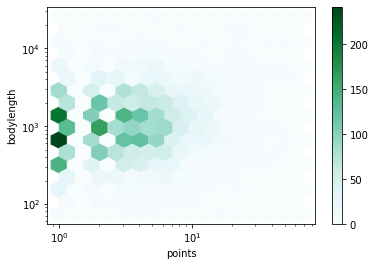

In [88]:
pointslength.plot.hexbin(x='points', y='bodylength', gridsize=15, xscale='log', yscale='log', sharex=False)

#### Average points per question at hour of day

Fig 1. Questions submitted per hour of the day
Fig 2. Points received by question posed at time of day


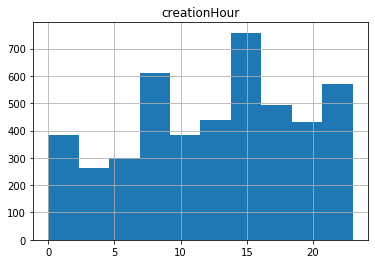

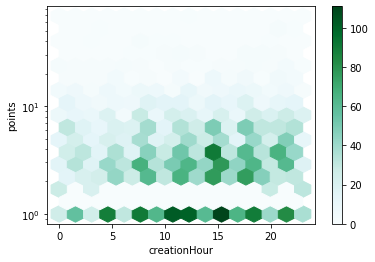

In [89]:
print("Fig 1. Questions submitted per hour of the day")
pointslength.hist('creationHour')
print("Fig 2. Points received by question posed at time of day")
pointslength.plot.hexbin(x='creationHour', y='points', gridsize=15, yscale='log', sharex=False)

In [90]:
removePunctuation(posts['Body'][5])

'pIve heard that the quality of a monte carlo ray tracer based on path tracing algorithms is much more realistic than a distributed stochastic engine I try to understand why but Im just at the beginning p\n\npIn order to dive into this topic and understand the basics can someone point me into the right direction What part of the algorithm leads into a more realistic render result p\n'

## Analysis with tokens

In [91]:
dfmini = pd.DataFrame(columns=["body", "points", "postType"])
tokenizer = RegexpTokenizer(r'\w+')

dfmini["body"] = posts['Body'].apply(lambda x: tokenizer.tokenize(x.lower()))
dfmini["points"] = posts['Score']
dfmini["postType"] = posts["PostTypeId"]

# PostTypeId 1 = Question, 2 = Answer
dfmini.head(20)

,body,points,postType
0,"[p, i, saw, a, a, href, https, www, youtube, c...",8,1
1,"[p, the, convention, in, graphics, is, that, p...",11,1
2,"[p, sometimes, i, use, vector, graphics, simpl...",20,1
3,"[p, i, just, implemented, some, interpolated, ...",11,1
4,"[p, i, have, an, opengl, application, which, u...",11,1
5,"[p, i, ve, heard, that, the, quality, of, a, m...",30,1
6,"[p, there, might, be, p, p, less, technical, a...",8,2
7,"[p, a, few, years, ago, i, tried, to, implemen...",17,1
8,"[p, as, thebuzzsaw, said, it, does, depend, on...",15,2
9,"[p, updating, an, area, of, memory, in, the, g...",11,2


## Lemmatize

In [92]:
dfmini['body'] = dfmini['body'].apply(lambda x: lemmatizeText(x))

In [93]:
dfmini['body'].head()

0    [p, i, saw, a, a, href, http, www, youtube, co...
1    [p, the, convention, in, graphic, is, that, pe...
2    [p, sometimes, i, use, vector, graphic, simply...
3    [p, i, just, implemented, some, interpolated, ...
4    [p, i, have, an, opengl, application, which, u...
Name: body, dtype: object

## StopWord Removal

In [94]:
dfmini['body'] = dfmini['body'].apply(lambda x: removeStopWordsFromArray(x))
dfmini['body'].head(20)

0     [p, saw, href, http, www, youtube, com, watch,...
1     [p, convention, graphic, performing, fewer, st...
2     [p, sometimes, use, vector, graphic, simply, l...
3     [p, implemented, interpolated, texture, sampli...
4     [p, opengl, application, us, stencil, test, qu...
5     [p, heard, quality, monte, carlo, ray, tracer,...
6     [p, might, p, p, le, technical, answer, p, p, ...
7     [p, year, ago, tried, implement, href, http, h...
8     [p, thebuzzsaw, said, doe, depend, lot, thing,...
9     [p, updating, area, memory, graphic, device, t...
10    [p, wikipedia, href, http, en, wikipedia, org,...
11    [p, strong, distributed, ray, tracing, strong,...
12    [p, really, way, p, p, geometry, shader, invoc...
13    [p, 1978, edwin, catmull, jim, clark, defined,...
14    [blockquote, p, stencil, buffer, contains, per...
15    [p, term, distributed, ray, tracing, wa, origi...
16    [p, href, http, en, wikipedia, org, wiki, perl...
17    [p, stencil, buffer, unsigned, integer, bu

### Number of different words in our data set:

In [123]:
tokens = dfmini['body']

vocabulary = set()
type(tokens)
print(tokens[1]) # example of a message body.


for items in tokens:
    for word in items:
        vocabulary.add(word)
    
print(len(vocabulary)) # We have this many words.

['p', 'convention', 'graphic', 'performing', 'fewer', 'state', 'change', 'better', 'performing', 'state', 'change', 'switching', 'shaders', 'binding', 'buffer', 'binding', 'texture', 'etc', 'texture', 'faster', 'render', 'many', 'polygon', 'using', 'single', 'atlas', 'rendering', 'sprite', 'text', 'individually', 'bind', 'new', 'texture', 'polygon', 'p', 'p', 'doe', 'hold', 'true', 'continually', 'painting', 'texture', 'via', 'code', 'gltexsubimage2d', 'code', 'stream', 'data', 'coming', 'network', 'undergoes', 'processing', 'painted', 'texture', 'one', 'row', 'time', 'data', 'presented', 'visually', 'endless', 'scroll', 'p', 'p', 'would', 'better', 'painting', 'one', 'texture', 'rendered', 'one', 'large', 'rectangle', 'scrolling', 'painted', 'data', 'view', 'idea', 'would', 'one', 'two', 'texture', 'bound', 'given', 'time', 'continue', 'paint', 'p', 'p', 'paint', 'lot', 'little', 'rectangle', 'revealing', 'rectangle', 'painting', 'done', 'assume', 'would', 'bind', 'one', 'texture', 'p

## TF-IDF

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [142]:
%%time
questions = posts[pd.to_numeric(posts['PostTypeId']) == 1]['Body']
answers = posts[pd.to_numeric(posts['PostTypeId']) == 2]['Body']

questions.apply(lambda x : removePunctuation(removeHTML(removeURLs(removeTags(x)))))

tfid_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
feature_values = tfid_vectorizer.fit_transform(questions)
feature_names = tfid_vectorizer.get_feature_names()

Wall time: 2.76 s


#### TF-IDF Transformation

In [155]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform(questions)

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

df_cv_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
df_cv_idf.sort_values(by=['idf_weights'],ascending=False).head()


,idf_weights
ﬂoating,8.104144
gpwiki,8.104144
scanspacingstep,8.104144
scanout,8.104144
scanning_printing,8.104144


### Clean the data

In [116]:
%%time
snowball = EnglishStemmer()
number_pattern = re.compile(r'[0-9]*')

statistics = {}
for name in feature_names:
    feature = str(snowball.stem(re.sub(number_pattern, '', name)))
    if len(feature) < 4: continue
    if feature not in statistics.keys():
        statistics[feature] = 1
    else:
        statistics[feature] += 1

result = sort
ed(statistics.items(), key=operator.itemgetter(1))

Wall time: 44.4 ms


In [117]:
# The top 10 duplicates
for value in result[-10:][::-1]:
    print(value)

('reflect', 7)
('calcul', 6)
('rotat', 5)
('render', 5)
('generat', 5)
('float', 5)
('direct', 5)
('comput', 5)
('work', 4)
('vector', 4)


## Data Visualization

In [125]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [119]:
def convert_to_wordcloud(text):
    ''' Convert text to wordcloud '''
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

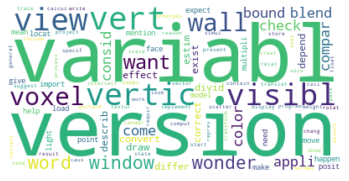

In [120]:
top_100 = " ".join(list(map(lambda x: x[0], result[-100:])))
convert_to_wordcloud(top_100)